# Tobacco 800 page stream segmentation experiments
> Image CNN

* img_training.ipynb
* train_text_cnn.ipynb
* text_activations.ipynb
* img_activations.ipynb
* sequence_clf_from_embs.ipynb
    * alterar a label

**Imports**

In [1]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

**Seed**

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

# tensorflow RNG
# tf.random.set_seed(seed)

## Load Data

In [7]:
path = Path("/mnt/nas/databases/Tobacco800/unziped/page_imgs/raw")

In [9]:
images = get_image_files(path)

In [215]:
df = pd.read_csv('/mnt/nas/databases/Tobacco800/unziped/train.csv', delimiter=';',  usecols=['binder','docid','class'])

In [216]:
df.head()

,binder,docid,class
0,Tobacco800,aah97e00-page02_1,FirstPage
1,Tobacco800,aah97e00-page02_2,NextPage
2,Tobacco800,aam09c00,FirstPage
3,Tobacco800,aao54e00_1,FirstPage
4,Tobacco800,aao54e00_2,NextPage


In [193]:
train_dist_df = df[:-200]['class'].value_counts().to_frame()

In [ ]:
df[:-200]['class'].value_counts

In [83]:
def splitter(df):
    train = df[:-200].index.tolist()
    valid = df[-200:].index.tolist()
    return train,valid

In [84]:
def get_x(r): return path/f'{r["docid"]}.tif'
def get_y(r): return r['class']

In [85]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=splitter,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.9,
                                               do_flip=False, max_rotate=0,
                                               max_warp=0),
                               Normalize.from_stats(*imagenet_stats)])

In [90]:
#dblock.summary(df)

In [91]:
dls = dblock.dataloaders(df)

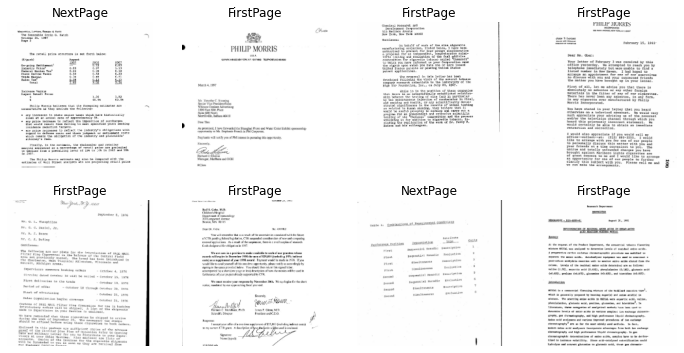

In [92]:
dls.show_batch(nrows=2, ncols=4)

## Train 

In [165]:
fscore = F1Score(average='weighted')

In [166]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, fscore], path='./')

In [167]:
learn.freeze()

In [168]:
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0008317637839354575)

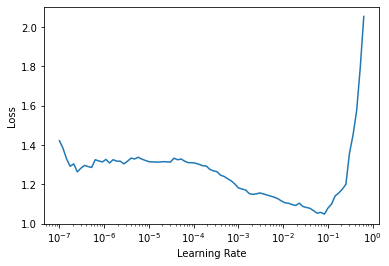

In [169]:
learn.lr_find()

In [170]:
learn.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.434282,2.277450,0.555000,0.479194,00:15


In [171]:
learn.unfreeze()
learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=4.365158383734524e-05)

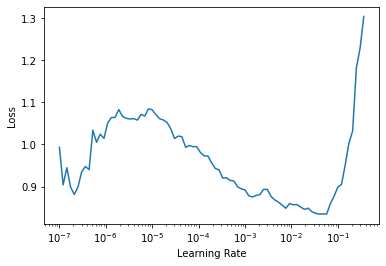

In [172]:
learn.lr_find()

In [182]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_image_no_weights_224'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.306043,1.312186,0.555000,0.406573,00:18
1,0.280893,1.093048,0.715000,0.708191,00:15
2,0.299006,0.742789,0.780000,0.780000,00:15
3,0.282686,0.712699,0.765000,0.764630,00:15


Better model found at epoch 0 with f1_score value: 0.40657314980210857.


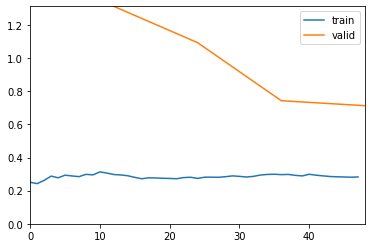

Better model found at epoch 1 with f1_score value: 0.7081910769932356.
Better model found at epoch 2 with f1_score value: 0.78.


In [183]:
learn.fit_one_cycle(4, lr_max=slice(2e-4,2e-3))

In [185]:
learn.load("best_image_no_weights_224")

/mnt/home/fabraz/code/fastai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [186]:
preds, targets = learn.get_preds()
preds = np.argmax(preds, axis=1)
print(classification_report(targets, preds, target_names=dls.vocab, digits=4))

              precision    recall  f1-score   support

   FirstPage     0.7156    0.8571    0.7800        91
    NextPage     0.8571    0.7156    0.7800       109

    accuracy                         0.7800       200
   macro avg     0.7864    0.7864    0.7800       200
weighted avg     0.7927    0.7800    0.7800       200



In [179]:
n_samples = len(dls.train_ds); n_samples

831